# GAN(Generative Adversarial Network)

In [13]:
import torch
import torch.nn as nn 

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [14]:
latent_dim = 100

# Generator 정의
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize=False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, 1 * 28 * 28),
        nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), 1, 28, 28)
    return img

In [15]:
# Discriminator 정의
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1 * 28 * 28, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    flattened = img.view(img.size(0), -1)
    output = self.model(flattened)

    return output

In [7]:
transforms_train = transforms.Compose([
                                       transforms.Resize(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [16]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.4, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [19]:
import time

n_epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(n_epochs):
  for i, (imgs, _) in enumerate(dataloader):

    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

    real_imgs = imgs.cuda()

    # Generator 학습
    optimizer_G.zero_grad()

    z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

    generated_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    g_loss.backward()
    optimizer_G.step()

    # Discriminator 학습
    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i
    if done % sample_interval == 0:
      save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

  print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.542764] [G loss: 0.606365] [Elapsed time: 10.34s]
[Epoch 1/200] [D loss: 0.366408] [G loss: 1.244652] [Elapsed time: 20.59s]
[Epoch 2/200] [D loss: 0.487972] [G loss: 0.854815] [Elapsed time: 30.89s]
[Epoch 3/200] [D loss: 0.285980] [G loss: 1.176613] [Elapsed time: 41.34s]
[Epoch 4/200] [D loss: 0.619405] [G loss: 2.277216] [Elapsed time: 51.65s]
[Epoch 5/200] [D loss: 0.295843] [G loss: 1.322791] [Elapsed time: 62.16s]
[Epoch 6/200] [D loss: 0.353367] [G loss: 0.971827] [Elapsed time: 72.62s]
[Epoch 7/200] [D loss: 0.239866] [G loss: 1.418965] [Elapsed time: 83.00s]
[Epoch 8/200] [D loss: 0.284275] [G loss: 1.536444] [Elapsed time: 93.59s]
[Epoch 9/200] [D loss: 0.231691] [G loss: 2.481185] [Elapsed time: 103.91s]
[Epoch 10/200] [D loss: 0.308856] [G loss: 1.127997] [Elapsed time: 114.25s]
[Epoch 11/200] [D loss: 0.372584] [G loss: 2.434726] [Elapsed time: 124.55s]
[Epoch 12/200] [D loss: 0.249732] [G loss: 2.104419] [Elapsed time: 134.78s]
[Epoch 13/200] [D 

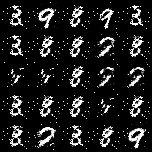

In [20]:
from IPython.display import Image

Image('92000.png')